In [11]:
import os
import sys
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import math
import random
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn

from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms


use_cuda = True
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [12]:
class Network_ANN(nn.Module):
    def __init__(self):
        super(Network_ANN, self).__init__()
        self.linear_dim = 8192
        
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,stride=1,padding=1,bias=False)
        self.HalfRect1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.subsample1 = nn.AvgPool2d(2,2,0)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1,bias=False)
        self.HalfRect2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.subsample2 = nn.AvgPool2d(2, 2, 0)
        self.fc1 = nn.Linear(self.linear_dim, 10, bias=False)
        self.HalfRect3 = nn.ReLU()

    def to(self, device):
        self.device = device
        super().to(device)
        return self

    def forward(self, input):
        x = self.conv1(input)
        x = self.HalfRect1(x)
        x = self.dropout1(x)
        x = self.subsample1(x)
        x = self.conv2(x)
        x = self.HalfRect2(x)
        x = self.dropout2(x)
        x = self.subsample2(x)
        x = x.view(-1,self.linear_dim)
        x = self.fc1(x)
        x = self.HalfRect3(x)
        return x

    def normalize_nn(self, train_loader):
        conv1_weight_max = torch.max(F.relu(self.conv1.weight))
        conv2_weight_max = torch.max(F.relu(self.conv2.weight))
        fc1_weight_max = torch.max(F.relu(self.fc1.weight))
        conv1_activation_max = 0.0
        conv2_activation_max = 0.0
        fc1_activation_max = 0.0

        self.eval()
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            x = inputs.float().to(self.device)
            x = self.dropout1(self.HalfRect2(self.conv1(x)))
            conv1_activation_max = max(conv1_activation_max, torch.max(x))
            x = self.subsample1(x)
            x = self.dropout2(self.HalfRect2(self.conv2(x)))
            conv2_activation_max = max(conv2_activation_max, torch.max(x))
            x = self.subsample2(x)
            x = x.view(-1, self.linear_dim)
            x = self.HalfRect3(self.fc1(x))
            fc1_activation_max = max(fc1_activation_max, torch.max(x))
        self.train()

        self.factor_log = []
        previous_factor = 1

        scale_factor = max(conv1_weight_max, conv1_activation_max)
        applied_inv_factor = (scale_factor / previous_factor).item()
        self.conv1.weight.data = self.conv1.weight.data / applied_inv_factor
        self.factor_log.append(1/ applied_inv_factor)
        previous_factor = applied_inv_factor

        scale_factor = max(conv2_weight_max, conv2_activation_max)
        applied_inv_factor = (scale_factor / previous_factor).item()
        self.conv2.weight.data = self.conv2.weight.data / applied_inv_factor
        self.factor_log.append(1 / applied_inv_factor)
        previous_factor = applied_inv_factor

        scale_factor = max(fc1_weight_max, fc1_activation_max)
        applied_inv_factor = (scale_factor / previous_factor).item()
        self.fc1.weight.data = self.fc1.weight.data / applied_inv_factor
        self.factor_log.append(1 / applied_inv_factor)
        previous_factor = applied_inv_factor
        

In [13]:
class STDB(torch.autograd.Function):
    
    alpha = ''
    beta = ''
    
    @staticmethod
    def forward(ctx, input, last_spike):
        ctx.save_for_backward(last_spike)
        out = torch.zeros_like(input).to(device)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        last_spike, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = STDB.alpha * torch.exp(-1*last_spike)**STDB.beta
        return grad*grad_input, None

    
def PoissonGen(inp, rescale_fac=2.0):
    rand_inp = torch.rand_like(inp).to(device)
    return torch.mul(torch.le(rand_inp * rescale_fac, torch.abs(inp)).float(), torch.sign(inp))


In [14]:
class Network_SNN(nn.Module):
    def __init__(self, time_window=30, max_rate=200, threshold=1.0, leak_factor=1.0, alpha=0.3, beta=0.01) -> None:
        super(Network_SNN, self).__init__()
        
        self.image_size = 64
        self.linear_dim = 8192
        
        self.leak_factor = leak_factor
        self.threshold = threshold
        self.spike = None
        
        self.spike_fn = STDB.apply
        STDB.alpha = alpha
        STDB.beta = beta 
        
        self.time_window = time_window
        self.dt = 0.001
        self.max_rate = max_rate
        self.rescale_factor = 1.0/(self.dt*self.max_rate)
        
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,stride=1,padding=1,bias=False)
        self.HalfRect1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.subsample1 = nn.AvgPool2d(2,2,0)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1,bias=False)
        self.HalfRect2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.subsample2 = nn.AvgPool2d(2, 2, 0)
        self.fc1 = nn.Linear(self.linear_dim, 10, bias=False)
        self.HalfRect3 = nn.ReLU()
        
        self.conv_list = [self.conv1, self.conv2]
        self.pool_list = [self.subsample1, self.subsample2]
        
        for m in self.modules():
            if (isinstance(m, nn.Conv2d)):
                m.threshold = self.threshold
            elif (isinstance(m, nn.Linear)):
                m.threshold = self.threshold

    def to(self, device):
        self.device = device
        super().to(device)
        return self
    
    def init_spike(self, mem_conv_list):
        spike = [copy.deepcopy(i) for i in mem_conv_list]
        for values in spike:
            for value in values:
                value.fill_(-1000)
        self.spike = spike
    
    def forward(self, input):
        infer, _input = input
        batch_size = _input.size(0)
        
        input_spksum = torch.zeros(batch_size, self.conv1.in_channels, self.image_size, self.image_size).to(device)    
        mem_conv1 = torch.zeros(batch_size, self.conv1.out_channels, 64, 64).to(device)
        mem_conv2 = torch.zeros(batch_size, self.conv2.out_channels, 32, 32).to(device)
        mem_fc1 = torch.zeros(batch_size, self.fc1.out_features).to(device)
        mem_conv_list = [mem_conv1, mem_conv2]
        self.init_spike(mem_conv_list)
        
        for t in range(self.time_window):
            
            if infer == 'Synth':
                _t = _input[:,t].view(batch_size, 1, self.image_size, self.image_size)
            else:
                _t = _input.view(batch_size, 1, self.image_size, self.image_size)
                
            spike_input = PoissonGen(_t.to(device), self.rescale_factor)
            input_spksum += spike_input
            out_prev = spike_input
            
            for idx in range(len(self.conv_list)):                
                mem_conv_list[idx] = self.leak_factor * mem_conv_list[idx] + self.conv_list[idx](out_prev)
                mem_thr = (mem_conv_list[idx] / self.conv_list[idx].threshold) - 1.0
                out = self.spike_fn(mem_thr, (t-1-self.spike[idx]))
                rst = torch.zeros_like(mem_conv_list[idx]).to(device)
                rst[mem_thr > 0] = self.conv_list[idx].threshold
                self.spike[idx] = self.spike[idx].masked_fill(out.bool(),t-1)
                mem_conv_list[idx] = mem_conv_list[idx] - rst
                out_prev = out.clone()
                
                out_prev = self.pool_list[idx](out_prev)
            
            out_prev = out_prev.reshape(batch_size, -1)
            
            mem_fc1 = mem_fc1 + self.fc1(out_prev)

        out_voltage = mem_fc1 / self.time_window

        return input_spksum, out_voltage


In [15]:
class BouncingMNISTDataHandler(object):
    def __init__(self, batch_size, seq_length, image_size, path='', pertubation=False, attack_info={}, digit_size=28) -> None:
        self.seq_length_ = seq_length
        self.batch_size_ = batch_size
        self.image_size_ = image_size
        self.num_digits_ = 1
        self.step_length_ = 0.1
        self.digit_size_ = digit_size
        self.frame_size_ = self.image_size_ ** 2
        self.pertubation = pertubation
        self.raw_ = False
            
        if not self.pertubation:
            try:
                f = h5py.File(path)
            except:
                print('Please set the correct path to MNIST dataset')
                sys.exit(0)
                
            self.data_ = f['inputs'][:].reshape(-1, self.digit_size_, self.digit_size_)
            self.labels_ = f['labels'][:][0]
            f.close()
        else:
            data_loader, epsilon = attack_info['data_loader'], attack_info['pertubation_strength']
            _X, _y = GenerateAdvExamples(attack_info['model'], data_loader, img_size=self.digit_size_, epsilon=epsilon)
            self.data_ = _X.numpy()
            self.labels_ = _y.numpy()
            self.raw_ = attack_info['raw']

        self.indices_ = np.arange(self.data_.shape[0])
        self.row_ = 0
        np.random.shuffle(self.indices_)
    
    def GetRandomTrajectory(self, batch_size):
        length = self.seq_length_
        canvas_size = self.image_size_ - self.digit_size_
    
        # Initial position uniform random inside the box.
        y = np.random.rand(batch_size)
        x = np.random.rand(batch_size)

        # Choose a random velocity.
        theta = np.random.rand(batch_size) * 2 * np.pi
        v_y = np.sin(theta)
        v_x = np.cos(theta)

        start_y = np.zeros((length, batch_size))
        start_x = np.zeros((length, batch_size))
        for i in range(length):
          # Take a step along velocity.
            y += v_y * self.step_length_
            x += v_x * self.step_length_
            
            # Bounce off edges.
            for j in range(batch_size):
                if x[j] <= 0:
                    x[j] = 0
                    v_x[j] = -v_x[j]
                if x[j] >= 1.0:
                    x[j] = 1.0
                    v_x[j] = -v_x[j]
                if y[j] <= 0:
                    y[j] = 0
                    v_y[j] = -v_y[j]
                if y[j] >= 1.0:
                    y[j] = 1.0
                    v_y[j] = -v_y[j]
            start_y[i, :] = y
            start_x[i, :] = x
        
        start_y = (canvas_size * start_y).astype(np.int32)
        start_x = (canvas_size * start_x).astype(np.int32)
        return start_y, start_x
    
    def Overlap(self, a, b):
        """ Put b on top of a."""
        if not self.raw_:
            return np.maximum(a, b)
        return b

    def GetBatch(self, verbose=False):
        start_y, start_x = self.GetRandomTrajectory(self.batch_size_ * self.num_digits_)
        # minibatch data
        data = np.zeros((self.batch_size_, self.seq_length_, self.image_size_, self.image_size_), dtype=np.float32)
        labels = np.zeros((self.batch_size_))

        for j in range(self.batch_size_):
            for n in range(self.num_digits_):

                # get random digit from dataset
                ind = self.indices_[self.row_]
                self.row_ += 1
                if self.row_ == self.data_.shape[0]:
                    self.row_ = 0
                    np.random.shuffle(self.indices_)
                digit_image = self.data_[ind, :, :]
                labels[j] = self.labels_[ind]

                # generate video
                for i in range(self.seq_length_):
                    top    = start_y[i, j * self.num_digits_ + n]
                    left   = start_x[i, j * self.num_digits_ + n]
                    bottom = top  + self.digit_size_
                    right  = left + self.digit_size_
                    data[j, i, top:bottom, left:right] = self.Overlap(data[j, i, top:bottom, left:right], digit_image)

        return data.reshape(self.batch_size_, -1), labels


In [16]:
def OrdinEval(model, params, train_loader=None, test_loader=None, arc='ANN'):
    model.eval()
    acc_record = list([])
    correct = 0
    total = 0

    with torch.no_grad():
        for split, loader in [('Train', train_loader), ('Test', test_loader)]:
            if loader is not None:
                for batch_idx, (inputs, targets) in enumerate(loader):
                    batch_sz = inputs.size(0)            
                    inputs = inputs.float().to(device)
                    labels_ = torch.zeros(batch_sz, 10).scatter_(1, targets.view(-1, 1), 1).to(device)

                    if arc == 'SNN':
                        _, outputs = model((params['infer_type'], inputs))
                    else:
                        outputs = model(inputs)
                    targets = targets.to(device)

                    loss = params['criterion'](outputs, labels_)
                    _, predicted = outputs.max(1)
                    total += float(targets.size(0))
                    correct += float(predicted.eq(targets).sum().cpu().item())
                print(arc, split, "Accuracy: %.3f" % (100 * correct / total))
                acc = 100. * float(correct) / float(total)
                acc_record.append(acc)


def OrdinTrainNEval(model, params, train_loader, test_loader, arc='ANN', verbose_interval=4):
    print(model,'\n','**********',arc,'Training **********')
    verbose_at = [int(len(train_loader)*i/verbose_interval) for i in range(1, verbose_interval+1)]

    for epoch in range(params['num_epochs']):
        model.train()
        running_loss = 0
        start_time = time.time()

        for i, (inputs, targets) in enumerate(train_loader):
            batch_sz = inputs.size(0)
            inputs = inputs.float().to(device)
            labels_ = torch.zeros(batch_sz, 10).scatter_(1, targets.view(-1, 1), 1).to(device)

            params['optimizer'].zero_grad()
            if arc == 'SNN':
                _, outputs = model((params['infer_type'], inputs))
            else:
                outputs = model(inputs)
                
            loss = params['criterion'](outputs, labels_)
            running_loss += loss.cpu().item()
            loss.backward()
            params['optimizer'].step()
            if i+1 in verbose_at:
                print ('Epoch [%d/%d], Step [%d/%d], Training Loss: %.5f Time elasped:%.2f s'
                      %(epoch+1, params['num_epochs'], i+1, len(train_loader),running_loss,time.time()-start_time))
                running_loss = 0
        OrdinEval(model, params, train_loader, test_loader, arc)


In [17]:
def displaySeq(images, titles=None, num_rows=2, num_cols=None):
    num_images = len(images)
    if num_cols is None:
        num_cols = math.ceil(num_images / num_rows)

    figsize = (num_cols * 2, num_rows * 2)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    for i, image in enumerate(images):
        row = i // num_cols
        col = i % num_cols

        if num_rows > 1:
            axes[row, col].imshow(image, cmap='gray')
            axes[row, col].axis('off')
            if titles is not None:
                axes[row, col].set_title(titles[i])
        else:
            axes[col].imshow(image, cmap='gray')
            axes[col].axis('off')
            if titles is not None:
                axes[col].set_title(titles[i])

    plt.tight_layout()
    plt.show()

def DataPreview(data):
    print(data.shape)
    displaySeq(data[random.randint(0, data.shape[0]-1)])


In [18]:
def SynthEval(MovingMNIST, model, params, arc='SNN', data_preview=False, eval_size=0.2, batch_scale_factor=2):
    MovingMNIST.batch_size_ *= batch_scale_factor
    img_size = MovingMNIST.image_size_
    
    model.eval()
    acc_record = list([])
    correct = 0
    total = 0

    with torch.no_grad():
        for i in range(int(params['num_batches']*eval_size)):
            X, y = MovingMNIST.GetBatch()
            batch_sz = X.shape[0]
            inputs = torch.from_numpy(X).reshape(batch_sz, params['seq_length'], img_size, img_size)
            targets = torch.from_numpy(y).reshape(-1).to(torch.int64)
            
            if data_preview and not i and arc == 'SNN':
                print('\n', '********** Data Preview **********')
                DataPreview(inputs)
           
            inputs = inputs.float().to(device)
            labels_ = torch.zeros(batch_sz, 10).scatter_(1, targets.view(-1, 1), 1).to(device)

            if arc == 'SNN':
                _, outputs = model((params['infer_type'], inputs))
            else:
                outputs = model(inputs[:, random.randint(0, params['seq_length']-1)].unsqueeze(1))
            targets = targets.to(device)

            loss = params['criterion'](outputs, labels_)
            _, predicted = outputs.max(1)
            total += float(targets.size(0))
            correct += float(predicted.eq(targets).sum().cpu().item())
            
        print("SNN Test Accuracy: %.3f" % (100 * correct / total))
        acc = 100. * float(correct) / float(total)
        acc_record.append(acc)
        MovingMNIST.batch_size_ //= batch_scale_factor

        
def SynthTrainNEval(MovingMNIST, model, params, arc='SNN', verbose_interval=4):
    print(model)
    img_size = MovingMNIST.image_size_
    verbose_at = [int(params['num_batches']*i/verbose_interval) for i in range(1, verbose_interval+1)]

    for epoch in range(params['num_epochs']):
        model.train()
        running_loss = 0
        start_time = time.time()

        for i in range(params['num_batches']):
            X, y = MovingMNIST.GetBatch()
            batch_sz = X.shape[0]
            inputs = torch.from_numpy(X).reshape(batch_sz, params['seq_length'], img_size, img_size)
            targets = torch.from_numpy(y).reshape(-1).to(torch.int64)
            
            if not epoch and not i:
                if arc == 'SNN':
                    print(' ********** Data Preview **********')
                    DataPreview(inputs)
                print(' **********', arc,'Training **********')

            inputs = inputs.float().to(device)
            labels_ = torch.zeros(batch_sz, 10).scatter_(1, targets.view(-1, 1), 1).to(device)

            params['optimizer'].zero_grad()
            if arc == 'SNN':
                _, outputs = model((params['infer_type'], inputs))
            else:
                outputs = model(inputs[:, random.randint(0, params['seq_length']-1)].unsqueeze(1))
                
            loss = params['criterion'](outputs, labels_)
            running_loss += loss.cpu().item()
            loss.backward()
            params['optimizer'].step()
            if i+1 in verbose_at:
                print ('Epoch [%d/%d], Step [%d/%d], Training Loss: %.5f Time elasped:%.2f s'
                      %(epoch+1,params['num_epochs'],i+1, params['num_batches'],running_loss,time.time()-start_time))
                running_loss = 0
        SynthEval(MovingMNIST, model, params, arc=arc)


In [19]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad    
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image

def GenerateAdvExamples(model, loader, img_size=28, epsilon=0.05):
    _X, _y = [], []
    for idx, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs.requires_grad = True

        outputs = model(inputs)
        init_pred = outputs.max(1, keepdim=True)[1]

        loss = F.nll_loss(outputs, targets)
        model.zero_grad()
        loss.backward()

        data_grad = inputs.grad.data
        perturbed_data = fgsm_attack(inputs, epsilon, data_grad)
        
        if idx != len(loader)-1:
            _X.append(perturbed_data)
            _y.append(targets)
    
    PertubatedX = torch.zeros((len(_X), loader.batch_size, 1, img_size, img_size))
    PertubatedY = torch.zeros((len(_y), loader.batch_size))
    for idx in range(len(_X)):
        if img_size == 28:
            PertubatedX[idx], PertubatedY[idx] = _X[idx][:, :, 18:46, 18:46], _y[idx]
        else:
            PertubatedX[idx], PertubatedY[idx] = _X[idx], _y[idx]
    PertubatedX, PertubatedY = PertubatedX.reshape(-1, 1, img_size, img_size).detach(), PertubatedY.reshape(-1)

    return PertubatedX, PertubatedY.to(torch.int64)


In [20]:
def mnist_transform(img_size, default=28):
    pad_xy = (img_size - default) // 2
    return transforms.Compose([
        transforms.Pad((pad_xy, pad_xy)),
        transforms.ToTensor()
    ])


img_size = 64
train_batch_size = 100
test_batch_size = train_batch_size * 2

mnist_train_dataset = torchvision.datasets.MNIST(root="D:\Dataset\mnist", train=True, download=True, transform=mnist_transform(img_size))
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=train_batch_size, shuffle=True)

mnist_test_dataset = torchvision.datasets.MNIST(root="D:\Dataset\mnist", train=False, download=True, transform=mnist_transform(img_size))
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=test_batch_size, shuffle=False)

# import shutil
# shutil.rmtree('/kaggle/working/D:\Dataset\mnist')

In [21]:
ANN = Network_ANN()
ANN.to(device)

ANN_Params = {
    'num_epochs' : 2,
    'optimizer' : optim.SGD(ANN.parameters(), lr=1, momentum=0.95),
    'criterion' : nn.MSELoss().to(device),
    'best_acc' : 0
}

ANN.load_state_dict(torch.load('/kaggle/working/MNIST_ANN.pth'))


# OrdinTrainNEval(ANN, ANN_Params, mnist_train_loader, mnist_test_loader)
OrdinEval(ANN, ANN_Params, mnist_train_loader, mnist_test_loader)


Normalized_ANN = Network_ANN()
Normalized_ANN.to(device)
Normalized_ANN.load_state_dict(ANN.state_dict())
print('\nNormalizing ANN...', end=' '); Normalized_ANN.normalize_nn(mnist_train_loader); print('Done')

#  ********** ANN Training **********
# Epoch [1/2], Step [150/600], Training Loss: 4.47829 Time elasped:7.58 s
# Epoch [1/2], Step [300/600], Training Loss: 2.20979 Time elasped:10.05 s
# Epoch [1/2], Step [450/600], Training Loss: 1.87656 Time elasped:12.53 s
# Epoch [1/2], Step [600/600], Training Loss: 1.62474 Time elasped:15.06 s
# ANN Train Accuracy: 97.892
# ANN Test Accuracy: 97.913
# Epoch [2/2], Step [150/600], Training Loss: 1.53044 Time elasped:2.53 s
# Epoch [2/2], Step [300/600], Training Loss: 1.44256 Time elasped:5.01 s
# Epoch [2/2], Step [450/600], Training Loss: 1.44758 Time elasped:7.57 s
# Epoch [2/2], Step [600/600], Training Loss: 1.41535 Time elasped:10.04 s
# ANN Train Accuracy: 98.305
# ANN Test Accuracy: 98.323

# torch.save(ANN.state_dict(), 'MNIST_ANN.pth')

ANN Train Accuracy: 98.305
ANN Test Accuracy: 98.323

Normalizing ANN... Done


In [15]:
# ANN = Network_ANN()
# ANN.to(device)

# movement_interval = 30
# num_batches = 600
# num_epochs = 2

# ANN_Params = {
#     'seq_length' : movement_interval, 'num_batches' : num_batches, 'num_epochs' : num_epochs,
#     'optimizer' : optim.SGD(ANN.parameters(), lr=1, momentum=0.95), 'criterion' : nn.MSELoss().to(device),
#     'infer_type' : 'Ordin', 'best_acc' : 0
# }

# ANN_MovingMNIST = BouncingMNISTDataHandler(batch_size=train_batch_size, seq_length=movement_interval, image_size=img_size,
#                                       path='/kaggle/input/mnist-h5/mnist.h5')


# SynthTrainNEval(ANN_MovingMNIST, ANN, ANN_Params, arc='ANN')


# Normalized_ANN = Network_ANN()
# Normalized_ANN.to(device)
# Normalized_ANN.load_state_dict(ANN.state_dict())
# print('\nNormalizing ANN...', end=' '); Normalized_ANN.normalize_nn(mnist_train_loader); print('Done')

In [39]:
# ANN2SNN = Network_SNN(time_window=time_window, max_rate=max_rate)
# ANN2SNN.to(device)
# ANN2SNN.load_state_dict(Normalized_ANN.state_dict())

# ANN2SNN_Params = {
#     'seq_length' : time_window, 'num_batches' : num_batches, 'num_epochs' : num_epochs,
#     'optimizer' : optim.Adam(ANN2SNN.parameters()), 'criterion' : nn.MSELoss().to(device),
#     'infer_type' : 'Ordin', 'best_acc' : 0
# }

# OrdinEval(ANN2SNN, ANN2SNN_Params, test_loader=mnist_test_loader, arc='SNN')

(Perturbation Strength: 0.05) ANN Test Accuracy: 96.633
(Perturbation Strength: 0.1) ANN Test Accuracy: 92.969
(Perturbation Strength: 0.15) ANN Test Accuracy: 83.878
(Perturbation Strength: 0.2) ANN Test Accuracy: 66.551
(Perturbation Strength: 0.25) ANN Test Accuracy: 48.724
(Perturbation Strength: 0.3) ANN Test Accuracy: 36.541
\Perturbed Data (Range: 0.05 - 0.3)


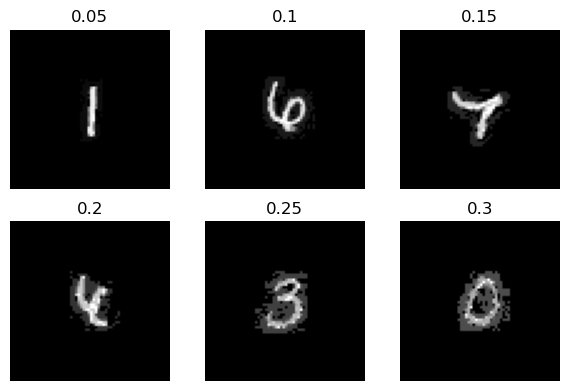

In [22]:
data_loader = mnist_test_loader
pertubation_strengths = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
Example_X = torch.zeros((len(pertubation_strengths), img_size, img_size))

for idx, pertubation_strength in enumerate(pertubation_strengths):
    _X, _y = GenerateAdvExamples(ANN, data_loader, img_size=img_size, epsilon=pertubation_strength)
#     Zeroed_X = np.zeros((_X.shape[0], 1, img_size, img_size))
#     Zeroed_X[:, :, 18:46, 18:46] = np.maximum(Zeroed_X[:, :, 18:46, 18:46], _X.numpy())

    pertubated_mnist_dataset = TensorDataset(_X, _y)
    pertubated_mnist_loader = DataLoader(pertubated_mnist_dataset, batch_size=data_loader.batch_size, shuffle=False)

    Example_X[idx] = next(iter(pertubated_mnist_loader))[0][random.randint(0, pertubated_mnist_loader.batch_size-1)]

    print('(Perturbation Strength:', str(pertubation_strength)+')', end=' ')
    # ANN Pertubated Test Accuracy
    OrdinEval(ANN, ANN_Params, test_loader=pertubated_mnist_loader)

    
print('\Perturbed Data (Range:', pertubation_strengths[0], '-', str(pertubation_strengths[-1])+')')
displaySeq(Example_X, titles=list(map(lambda i : str(i), pertubation_strengths)))

In [17]:
# # MNIST -> MovingMNIST

# time_window = 20
# max_rate = 400

# batch_size = 100
# num_batches = 800
# num_epochs = 2


# SNN = Network_SNN(time_window=time_window, max_rate=max_rate)
# SNN.to(device)
# SNN.load_state_dict(Normalized_ANN.state_dict())

# MovingMNIST = BouncingMNISTDataHandler(batch_size=batch_size, seq_length=time_window, image_size=img_size,
#                                       path='/kaggle/input/mnist-h5/mnist.h5')

# SNN_Params = {
#     'seq_length' : time_window, 'num_batches' : num_batches, 'num_epochs' : num_epochs,
#     'optimizer' : optim.Adam(SNN.parameters()), 'criterion' : nn.MSELoss().to(device),
#     'infer_type' : 'Ordin', 'best_acc' : 0
# }


# OrdinTrainNEval(SNN, SNN_Params, mnist_train_loader, mnist_test_loader, arc='SNN'); print()

# SNN_Params['infer_type'] = 'Synth'
# MovingMNIST.seq_length_ = 30

# SNN.time_window = 30
# SNN.max_rate = 800
# SNN.rescale_factor = 1.0/(SNN.dt*SNN.max_rate)

# SNN_Params['seq_length'] = SNN.time_window
# SNN_Params['num_epochs'] = 4

# SynthTrainNEval(MovingMNIST, SNN, SNN_Params)

Network_SNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (HalfRect1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (subsample1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (HalfRect2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (subsample2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=8192, out_features=10, bias=False)
  (HalfRect3): ReLU()
)
 ********** Data Preview **********
torch.Size([100, 30, 64, 64])


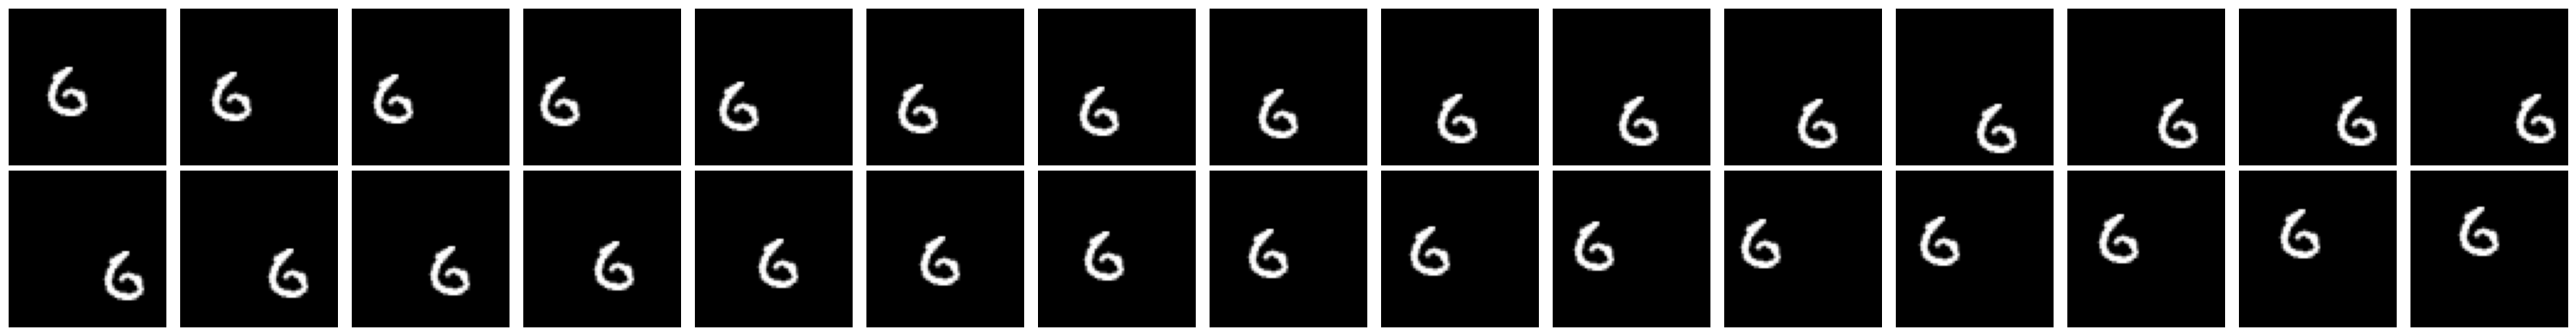

 ********** SNN Training **********
Epoch [1/4], Step [200/800], Training Loss: 18.21718 Time elasped:52.31 s
Epoch [1/4], Step [400/800], Training Loss: 12.64678 Time elasped:103.48 s
Epoch [1/4], Step [600/800], Training Loss: 10.90344 Time elasped:154.62 s
Epoch [1/4], Step [800/800], Training Loss: 10.18572 Time elasped:205.86 s
SNN Test Accuracy: 82.944
Epoch [2/4], Step [200/800], Training Loss: 9.68273 Time elasped:51.16 s
Epoch [2/4], Step [400/800], Training Loss: 9.42231 Time elasped:102.30 s
Epoch [2/4], Step [600/800], Training Loss: 9.25598 Time elasped:153.50 s
Epoch [2/4], Step [800/800], Training Loss: 8.97732 Time elasped:204.65 s
SNN Test Accuracy: 87.472
Epoch [3/4], Step [200/800], Training Loss: 8.95458 Time elasped:51.03 s
Epoch [3/4], Step [400/800], Training Loss: 8.86258 Time elasped:102.21 s
Epoch [3/4], Step [600/800], Training Loss: 8.68462 Time elasped:153.33 s
Epoch [3/4], Step [800/800], Training Loss: 8.67119 Time elasped:204.50 s
SNN Test Accuracy: 87.4

In [44]:
# MovingMNIST - Transfer - MNIST

time_window = 30
max_rate = 800

batch_size = 100
num_batches = 800
num_epochs = 2


SNN = Network_SNN(time_window=time_window, max_rate=max_rate)
SNN.to(device)
SNN.load_state_dict(Normalized_ANN.state_dict())

MovingMNIST = BouncingMNISTDataHandler(batch_size=batch_size, seq_length=time_window, image_size=img_size,
                                      path='/kaggle/input/mnist-h5/mnist.h5')

SNN_Params = {
    'seq_length' : time_window, 'num_batches' : num_batches, 'num_epochs' : num_epochs,
    'optimizer' : optim.Adam(SNN.parameters()), 'criterion' : nn.MSELoss().to(device),
    'infer_type' : 'Synth', 'best_acc' : 0
}


SynthTrainNEval(MovingMNIST, SNN, SNN_Params); print()

for name, param in SNN.named_parameters():
    if name in ['conv1.weight', 'conv2.weight']:
        param.requires_grad = False

# SNN.time_window = 30
# SNN.max_rate = 800
# SNN.rescale_factor = 1.0/(SNN.dt*SNN.max_rate)

# SNN_Params['seq_length'] = SNN.time_window
        
SNN_Params['infer_type'] = 'Ordin' 
# SNN_Params['optimizer'] = optim.Adam(SNN.parameters())
# SNN_Params['num_epochs'] = 2
        
OrdinTrainNEval(SNN, SNN_Params, mnist_train_loader, mnist_test_loader, arc='SNN')

In [18]:
time_window = 30
max_rate = 800

batch_size = 100
num_batches = 800
num_epochs = 2


_SNN = Network_SNN(time_window=time_window, max_rate=max_rate)
_SNN.to(device)
_SNN.load_state_dict(Normalized_ANN.state_dict())

_SNN_Params = {
    'seq_length' : time_window, 'num_batches' : num_batches, 'num_epochs' : num_epochs,
    'optimizer' : optim.Adam(_SNN.parameters()), 'criterion' : nn.MSELoss().to(device),
    'infer_type' : 'Ordin', 'best_acc' : 0
}


OrdinTrainNEval(_SNN, _SNN_Params, mnist_train_loader, mnist_test_loader, arc='SNN')

Network_SNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (HalfRect1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (subsample1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (HalfRect2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (subsample2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=8192, out_features=10, bias=False)
  (HalfRect3): ReLU()
) 
 ********** SNN Training **********
Epoch [1/2], Step [150/600], Training Loss: 4.12417 Time elasped:36.68 s
Epoch [1/2], Step [300/600], Training Loss: 2.34371 Time elasped:73.34 s
Epoch [1/2], Step [450/600], Training Loss: 2.04335 Time elasped:110.02 s
Epoch [1/2], Step [600/600], Training Loss: 1.87787 Time elasped:146.69 s
SNN Train Accuracy: 98.223
SNN Test Accuracy: 98.240
Epoch [2/2], Step [150/600], Training Loss: 1.77525 Time elasped:36.60 s
Epoch [2/2

In [48]:
# MovingMNIST - Transfer - MNIST

_X, _y = GenerateAdvExamples(ANN, mnist_test_loader, img_size, 0.15)
perturbed_mnist_test_set = TensorDataset(_X, _y)
perturbed_mnist_test_loader = DataLoader(perturbed_mnist_test_set, batch_size=mnist_test_loader.batch_size, shuffle=False)


print('MNIST Trained | PerturbedMNIST -', end=' '); OrdinEval(_SNN, _SNN_Params, test_loader=perturbed_mnist_test_loader, arc='SNN')

SNN.time_window = time_window
SNN.max_rate = max_rate
SNN.rescale_factor = 1.0/(SNN.dt*SNN.max_rate)

# SNN_Params['infer_type'] = 'Ordin'
SNN_Params['seq_length'] = SNN.time_window

print('MovingMNIST Transfer MNIST Trained | PerturbedMNIST -', end=' '); OrdinEval(SNN, SNN_Params, test_loader=perturbed_mnist_test_loader, arc='SNN')

SNN.time_window = 10
SNN.max_rate = 600
SNN.rescale_factor = 1.0/(SNN.dt*SNN.max_rate)

SNN_Params['seq_length'] = SNN.time_window

print('MovingMNIST Transfer MNIST Trained (Altered) | PerturbedMNIST -', end=' ')
OrdinEval(SNN, SNN_Params, test_loader=perturbed_mnist_test_loader, arc='SNN')

# MNIST Trained | PerturbedMNIST - SNN Test Accuracy: 88.316
# MovingMNIST Transfer MNIST Trained | PerturbedMNIST - SNN Test Accuracy: 77.867
# MovingMNIST Transfer MNIST Trained (Altered) | PerturbedMNIST - SNN Test Accuracy: 89.347

# MovingMNIST Transfer MNIST Trained | PerturbedMNIST - SNN Test Accuracy: 80.735
# MovingMNIST Transfer MNIST Trained (Altered) | PerturbedMNIST - SNN Test Accuracy: 90.469

# MNIST Trained | PerturbedMNIST - SNN Test Accuracy: 89.082
# MovingMNIST Transfer MNIST Trained | PerturbedMNIST - SNN Test Accuracy: 60.663
# MovingMNIST Transfer MNIST Trained (Altered) | PerturbedMNIST - SNN Test Accuracy: 70.643

MNIST Trained | PerturbedMNIST - SNN Test Accuracy: 88.837
MovingMNIST Transfer MNIST Trained | PerturbedMNIST - SNN Test Accuracy: 75.735
MovingMNIST Transfer MNIST Trained (Altered) | PerturbedMNIST - SNN Test Accuracy: 86.408


In [81]:
# # MNIST -> MovingMNIST

# _X, _y = GenerateAdvExamples(ANN, mnist_test_loader, img_size, 0.15)
# perturbed_mnist_test_set = TensorDataset(_X, _y)
# perturbed_mnist_test_loader = DataLoader(perturbed_mnist_test_set, batch_size=mnist_test_loader.batch_size, shuffle=False)


# # SNN.time_window = 20
# # SNN.max_rate = 400
# # SNN.rescale_factor = 1.0/(SNN.dt*SNN.max_rate)

# # SNN_Params['seq_length'] = SNN.time_window
# SNN_Params['infer_type'] = 'Ordin'


# print('MovingMNIST Trained | MNIST -', end=' '); OrdinEval(SNN, SNN_Params, test_loader=mnist_test_loader, arc='SNN')
# print('MNIST Trained | MNIST -', end=' '); OrdinEval(_SNN, _SNN_Params, test_loader=mnist_test_loader, arc='SNN')

# print('MovingMNIST Trained | PerturbedMNIST -', end=' '); OrdinEval(SNN, SNN_Params, test_loader=perturbed_mnist_test_loader, arc='SNN')
# print('MNIST Trained | PerturbedMNIST -', end=' '); OrdinEval(_SNN, _SNN_Params, test_loader=perturbed_mnist_test_loader, arc='SNN')

# # MovingMNIST Trained | MNIST - SNN Test Accuracy: 24.170
# # MNIST Trained | MNIST - SNN Test Accuracy: 98.540
# # MovingMNIST Trained | PerturbedMNIST - SNN Test Accuracy: 12.204
# # MNIST Trained | PerturbedMNIST - SNN Test Accuracy: 88.673

MovingMNIST Trained | MNIST - SNN Test Accuracy: 24.170
MNIST Trained | MNIST - SNN Test Accuracy: 98.540
MovingMNIST Trained | PerturbedMNIST - SNN Test Accuracy: 12.204
MNIST Trained | PerturbedMNIST - SNN Test Accuracy: 88.673



 ********** Data Preview **********
torch.Size([200, 30, 64, 64])


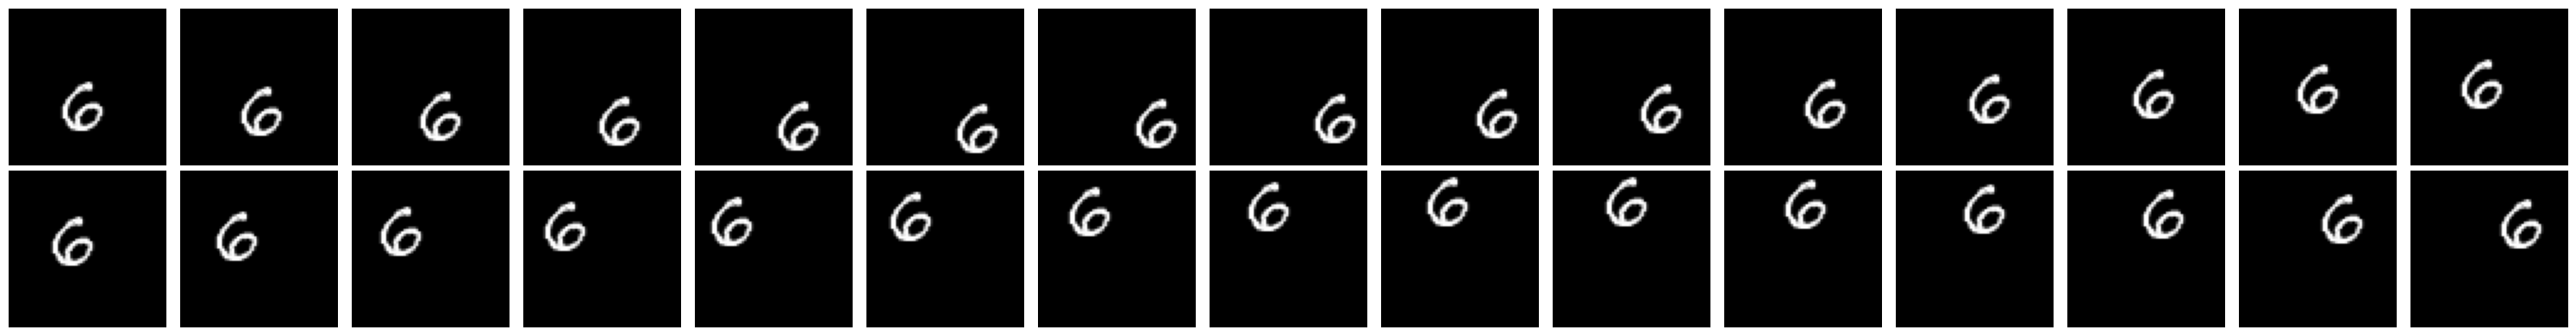

SNN Test Accuracy: 87.638

 ********** Data Preview **********
torch.Size([200, 30, 64, 64])


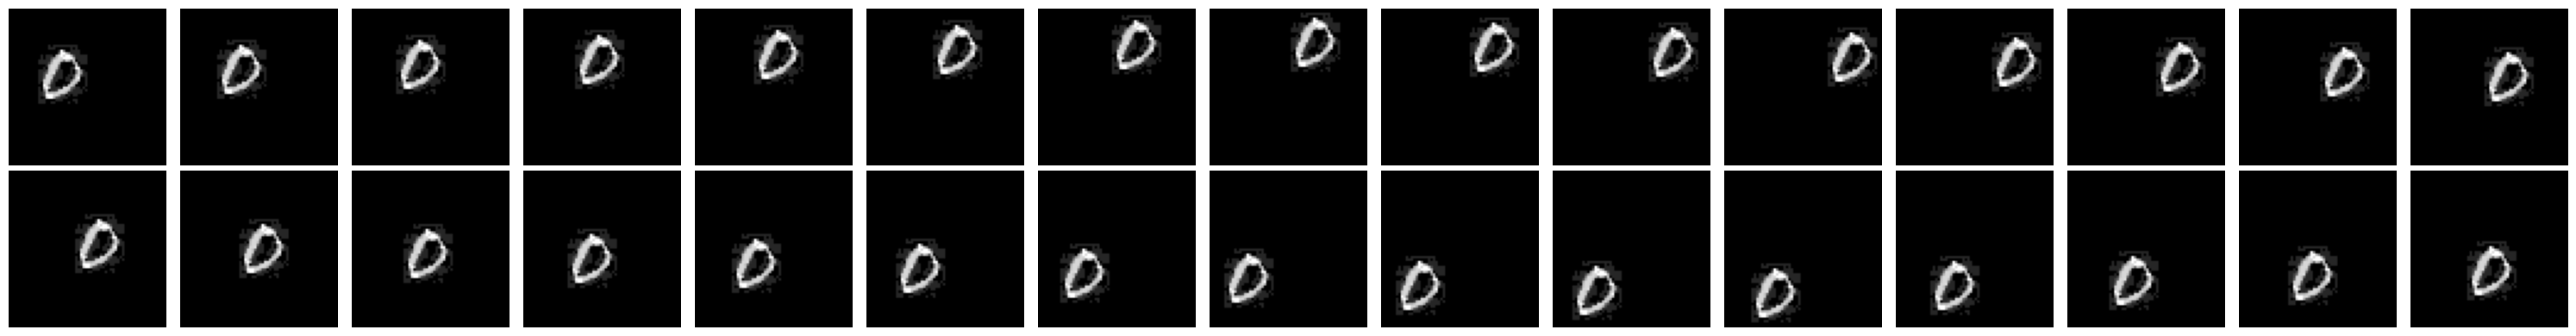

SNN Test Accuracy: 56.784


In [57]:
# attack_info = {
#     'model' : ANN,
#     'data_loader' : data_loader,
#     'pertubation_strength' : 0.15,
#     'raw' : True
# }

# PerturbedMovingMNIST = BouncingMNISTDataHandler(batch_size=batch_size, seq_length=SNN.time_window,
#                                                  image_size=img_size, pertubation=True, attack_info=attack_info)
# SNN_Params['infer_type'] = 'Synth'


# SynthEval(MovingMNIST, SNN, SNN_Params, data_preview=True)
# # SNN Pertubated Test Accuracy
# SynthEval(PerturbedMovingMNIST, SNN, SNN_Params, data_preview=True)

In [ ]:
# _SNN = Network_SNN(time_window=30, max_rate=1000)
# _SNN.to(device)
# PerturbedMovingMNIST.raw_ = True


# for DataHandler in [MovingMNIST, PerturbedMovingMNIST]:
#     X, y = DataHandler.GetBatch()
#     X = torch.from_numpy(X.reshape(100, -1, 64, 64)).to(device)
#     input_spksum, outputs = _SNN(('Synth', X))


#     for seq in X[:2].cpu():
#         displaySeq(seq)
#     for spksum in input_spksum[:2].squeeze(1).cpu():
#         plt.imshow(spksum, cmap='gray')
#         plt.show()